In [1]:
import json
import os
import re
from typing import List, Tuple

import matplotlib.pyplot as plt
from matplotlib.axes import Axes
import numpy as np
import pandas as pd
import requests
import seaborn as sns
import tqdm

In [2]:
wikidata_user_agent = "ask_type_query/0.1 (federico.belotti@unimib.it))"

### Alligator analysis

In [3]:
gt_path = "/home/belerico/Desktop/unimib/business cases/gh/gh_test_babak/gt/cea_gt.csv"
tables_path = "/home/belerico/Desktop/unimib/business cases/gh/gh_test_babak/tables/"
results_dir = "/home/belerico/Desktop/unimib/business cases/gh/gh_test_babak_results_alligator/"

In [4]:
dataset_name = "gh-test-babak-end-to-end"

In [5]:
gt = pd.read_csv(gt_path, header=None)
gt.columns = ["table_name", "row", "col", "qid"]
tables_names = gt["table_name"].unique().tolist()
url_regex = re.compile(r"http(s)?\:\/\/www\.wikidata\.org\/(wiki|entity)\/")
gt["qid"] = gt["qid"].map(lambda x: url_regex.sub("", x))
gt_mapping = {f"{row.table_name}-{row.row}-{row.col}": {"target": row.qid} for row in gt.itertuples()}

In [6]:
gt

,table_name,row,col,qid
0,Github_Testset,1,0,NIL
1,Github_Testset,2,0,NIL
2,Github_Testset,3,0,NIL
3,Github_Testset,4,0,NIL
4,Github_Testset,5,0,NIL
...,...,...,...,...
911,Github_Testset,912,0,Q986087
912,Github_Testset,913,0,Q99286585
913,Github_Testset,914,0,Q99287916
914,Github_Testset,915,0,Q99298800


In [7]:
read_from_server = False

In [8]:
if read_from_server:
    tp = 0
    annotations = []
    all_gt = len(gt)
    all_predicted = 0
    current_table = None
    current_table_name = None
    alligator_annotations = None
    for table_name in tqdm.tqdm(tables_names):
        if table_name != current_table_name:
            current_table_name = table_name
            response = requests.get(
                "http://localhost:5042/dataset/{}/table/{}?token=alligator_demo_2023".format(
                    dataset_name, current_table_name
                ),
                headers={
                    "accept": "application/json",
                    "Content-Type": "application/json",
                },
            )
            if response:
                alligator_annotations = response.json()
                annotations.append(alligator_annotations)
                alligator_annotations = alligator_annotations["semanticAnnotations"]["cea"]
            else:
                alligator_annotations = []
            for annotation in alligator_annotations:
                key = "{}-{}-{}".format(current_table_name, annotation["idRow"], annotation["idColumn"])
                # if key in gt_mapping_nil:
                #     continue
                if key not in gt_mapping:
                    continue
                predicted_qid = ""
                if len(annotation["entity"]) > 0:
                    all_predicted += 1
                    predicted_qid = annotation["entity"][0]["id"]
                if predicted_qid != "" and predicted_qid in gt_mapping[key]["target"]:
                    tp += 1

    # Print results
    precision = tp / all_predicted
    recall = tp / all_gt
    f1 = 2 * (precision * recall) / (precision + recall)
    print(all_gt, all_predicted)
    print("Precision: {:.4f}".format(precision))
    print("Recall: {:.4f}".format(recall))
    print("F1: {:.4f}".format(f1))

    # Save alligator results
    os.makedirs(os.path.join(results_dir, dataset_name), exist_ok=True)
    with open(os.path.join(results_dir, dataset_name, "alligator_annotations.json"), "w+") as f:
        json.dump(annotations, f)
else:
    with open(os.path.join(results_dir, dataset_name, "alligator_annotations.json"), "r") as f:
        annotations = json.load(open(os.path.join(results_dir, dataset_name, "alligator_annotations.json")))

In [9]:
gt_only_annotations = []

for i, table_annotations in enumerate(annotations):
    table = pd.read_csv(os.path.join(tables_path, "{}.csv".format(tables_names[i])))
    table = table.drop(columns=["idd", "id"])
    for annotation in table_annotations["semanticAnnotations"]["cea"]:
        key = "{}-{}-{}".format(tables_names[i], annotation["idRow"], annotation["idColumn"])
        if key not in gt_mapping:
            continue
        gt_only_annotations.append(annotation)
        gt_only_annotations[-1]["table_name"] = tables_names[i]
        gt_only_annotations[-1]["target"] = gt_mapping[key]["target"]
        gt_only_annotations[-1]["row"] = annotation["idRow"]
        gt_only_annotations[-1]["col"] = annotation["idColumn"]
        gt_only_annotations[-1]["mention"] = table.iloc[annotation["idRow"] - 1, annotation["idColumn"]]

In [10]:
len(gt_only_annotations)

916

In [11]:
features_df = []
for annotation in gt_only_annotations:
    if len(annotation["entity"]) > 0:
        features_df.append(
            {
                **{
                    "table_name": annotation["table_name"],
                    "row": annotation["row"],
                    "col": annotation["col"],
                    "mention": annotation["mention"],
                    "target": annotation["target"],
                },
                **(
                    {f["id"]: f["value"] for f in annotation["entity"][0]["features"]}
                    if len(annotation["entity"]) > 0
                    else {}
                ),
            }
    )
features_df = pd.DataFrame(features_df)
features_df

,table_name,row,col,mention,target,delta,omega,ncorrects_tokens,cpa_t4,p_subj_lit_datatype,...,p_subj_lit_row,p_subj_ne,ntoken_entity,jaccard_score,cpa_t3,desc,length_mention,es_score,popularity,ambiguity_mention
0,Github_Testset,102,0,Flare,NIL,0.001,0.010,1.0,0,0,...,0,0,1,1.00,0,0.000,5,1.000,0.00,0.809
1,Github_Testset,104,0,Trajano,NIL,0.013,0.024,1.0,0,0,...,0,0,1,1.00,0,0.000,7,1.000,0.00,0.225
2,Github_Testset,107,0,SNOW,NIL,0.002,0.009,1.0,0,0,...,0,0,1,1.00,0,0.000,4,0.971,0.00,0.959
3,Github_Testset,108,0,Elmagin Capital,NIL,0.001,0.009,0.5,0,0,...,0,0,1,0.50,0,0.000,15,1.000,0.00,0.000
4,Github_Testset,109,0,Code for IRAQ,NIL,0.001,0.011,1.0,0,0,...,0,0,3,0.67,0,0.000,13,0.961,0.00,0.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
665,Github_Testset,844,0,Alcon,Q684825,0.001,0.011,1.0,0,0,...,0,0,1,1.00,0,0.000,5,0.963,0.03,0.415
666,Github_Testset,846,0,banco de la rep blica,Q686329,0.383,0.402,0.8,0,0,...,0,0,4,0.60,0,0.000,21,0.939,0.02,0.000
667,Github_Testset,847,0,USI - University of Lugano,Q689617,0.500,0.541,1.0,0,0,...,0,0,3,0.60,0,0.333,26,1.000,0.02,0.000
668,Github_Testset,849,0,Mugla Sitki Koçman University,Q6944541,0.034,0.036,1.0,0,0,...,0,0,4,0.50,0,0.167,29,0.757,0.00,0.000


In [12]:
gt_only_annotations_df = []
for annotation in gt_only_annotations:
    gt_only_annotations_df.append(
        {
            "table_name": annotation["table_name"],
            "row": annotation["idRow"],
            "col": annotation["idColumn"],
            "candidates": len(annotation["entity"]),
            "score": annotation["entity"][0]["score"] if len(annotation["entity"]) > 0 else 0,
            "target": annotation["target"],
            "prediction": annotation["entity"][0]["id"] if len(annotation["entity"]) > 0 else "",
            "target_in_candidates": annotation["target"] in [c["id"] for c in annotation["entity"]],
            "mention": annotation["mention"],
        }
    )

In [13]:
gt_only_annotations_df = pd.DataFrame(gt_only_annotations_df)

In [14]:
gt_only_annotations_df

,table_name,row,col,candidates,score,target,prediction,target_in_candidates,mention
0,Github_Testset,101,0,0,0.000,NIL,,False,@bytemine-io
1,Github_Testset,102,0,50,0.024,NIL,Q17224798,False,Flare
2,Github_Testset,103,0,0,0.000,NIL,,False,Idelica
3,Github_Testset,104,0,31,0.040,NIL,Q37546733,False,Trajano
4,Github_Testset,105,0,0,0.000,NIL,,False,niway.dev
...,...,...,...,...,...,...,...,...,...
911,Github_Testset,846,0,49,0.430,Q686329,Q686329,True,banco de la rep blica
912,Github_Testset,847,0,42,0.603,Q689617,Q689617,True,USI - University of Lugano
913,Github_Testset,848,0,0,0.000,Q690639,,False,https://www.aau.at
914,Github_Testset,849,0,35,0.038,Q6944541,Q6944541,True,Mugla Sitki Koçman University


In [15]:
gt_only_annotations_df["alligator_match"] = (
    np.where(
        gt_only_annotations_df["candidates"] > 0,
        gt_only_annotations_df["prediction"],
        "NIL",
    )
    == gt_only_annotations_df["target"]
).astype(int)

In [16]:
gt_only_annotations_df["nil_label"] = np.where(
    gt_only_annotations_df["target"].to_numpy() == "NIL", "NIL", "Not NIL"
)

In [17]:
gt_only_annotations_df_sub = gt_only_annotations_df.copy()
gt_only_annotations_df_sub

,table_name,row,col,candidates,score,target,prediction,target_in_candidates,mention,alligator_match,nil_label
0,Github_Testset,101,0,0,0.000,NIL,,False,@bytemine-io,1,NIL
1,Github_Testset,102,0,50,0.024,NIL,Q17224798,False,Flare,0,NIL
2,Github_Testset,103,0,0,0.000,NIL,,False,Idelica,1,NIL
3,Github_Testset,104,0,31,0.040,NIL,Q37546733,False,Trajano,0,NIL
4,Github_Testset,105,0,0,0.000,NIL,,False,niway.dev,1,NIL
...,...,...,...,...,...,...,...,...,...,...,...
911,Github_Testset,846,0,49,0.430,Q686329,Q686329,True,banco de la rep blica,1,Not NIL
912,Github_Testset,847,0,42,0.603,Q689617,Q689617,True,USI - University of Lugano,1,Not NIL
913,Github_Testset,848,0,0,0.000,Q690639,,False,https://www.aau.at,0,Not NIL
914,Github_Testset,849,0,35,0.038,Q6944541,Q6944541,True,Mugla Sitki Koçman University,1,Not NIL


In [18]:
gt_only_annotations_df_sub[["alligator_match"]].mean(axis=0)

alligator_match    0.407205
dtype: float64

In [19]:
gt_only_annotations_df_sub[gt_only_annotations_df_sub["target"] != "NIL"][["alligator_match"]].mean(axis=0)

alligator_match    0.433921
dtype: float64

In [20]:
gt_only_annotations_df_sub.groupby("nil_label")["nil_label"].value_counts()

nil_label
NIL        462
Not NIL    454
Name: count, dtype: int64

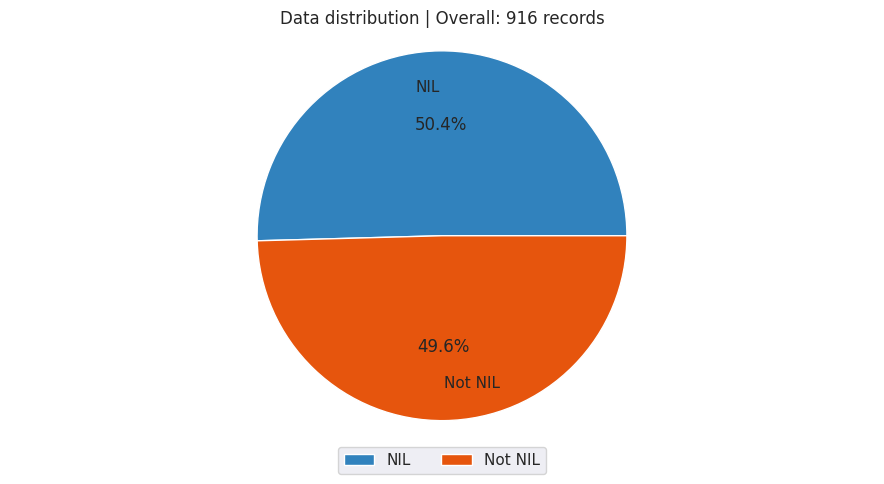

In [21]:
sns.set_context("paper")
sns.set(style="darkgrid")
fig, ax = plt.subplots(figsize=(9, 5))
size = 0.3
nil = gt_only_annotations_df_sub.groupby("nil_label")["nil_label"].value_counts()
vals = nil.to_numpy()
cmap = plt.get_cmap("tab20c")
inner_colors = cmap(np.arange(3) * 4)
ax.pie(
    vals.flatten(),
    colors=inner_colors,
    labels=["NIL", "Not NIL"],
    autopct="%1.1f%%",
    labeldistance=0.8,
    wedgeprops=dict(edgecolor="w"),
)

plt.legend()
sns.move_legend(ax, "upper center", bbox_to_anchor=(0.5, -0.0), ncol=3)
plt.axis("equal")
plt.title(f"Data distribution | Overall: {len(gt_only_annotations_df_sub)} records")
plt.tight_layout()
plt.show()

In [22]:
# Prediction with NIL threshold = 0.2
gt_only_annotations_df_sub["nil_prediction@0.2"] = np.where(
    (gt_only_annotations_df_sub["score"] >= 0.2) & (gt_only_annotations_df_sub["candidates"] > 0),
    gt_only_annotations_df_sub["prediction"],
    "NIL",
)
gt_only_annotations_df_sub["nil_match@0.2"] = (
    gt_only_annotations_df_sub["nil_prediction@0.2"] == gt_only_annotations_df_sub["target"]
).astype(int)

In [23]:
alligator_tp = 0
alligator_tn = 0
alligator_fn = 0
alligator_fp = 0
for i, (_, row) in enumerate(gt_only_annotations_df_sub.iterrows()):
    if row["candidates"] == 0:
        if row["nil_label"] == "NIL":
            alligator_tp += 1
        else:
            alligator_fp += 1
    elif row["candidates"] > 0:
        assert row.prediction != "NIL"
        if row["nil_label"] != "NIL":
            alligator_tn += 1
        else:
            # There's some candidates, score is above threshold but target is NIL
            alligator_fn += 1
    else:
        raise ValueError("Unexpected case")
alligator_recall = alligator_tp / (alligator_tp + alligator_fn)
alligator_precision = alligator_tp / (alligator_tp + alligator_fp)
alligator_f1 = 2 * (alligator_precision * alligator_recall) / (alligator_precision + alligator_recall)
alligator_acc = (alligator_tp + alligator_tn) / (alligator_tp + alligator_tn + alligator_fp + alligator_fn)
print("Alligator accuracy: {:.4f}".format(alligator_acc))
print("Precision: {:.4f}".format(alligator_precision))
print("Recall: {:.4f}".format(alligator_recall))
print("F1: {:.4f}".format(alligator_f1))

Alligator accuracy: 0.6114
Precision: 0.7154
Recall: 0.3810
F1: 0.4972


In [24]:
thresholds = np.linspace(0, 1, 25)
accuracies = []
precisions = []
recalls = []
f1s = []

for threshold in thresholds:
    tp = 0
    tn = 0
    fp = 0
    fn = 0
    predicted = 0
    annotations = 0
    for i, (_, row) in enumerate(gt_only_annotations_df_sub.iterrows()):
        if row["candidates"] == 0 or row["score"] <= threshold:  # If a prediction is NIL
            if row["nil_label"] == "NIL":
                tp += 1
            else:
                fp += 1
        elif row["candidates"] > 0:  # If a prediction is not NIL, i.e. a QID
            if row["nil_label"] != "NIL":
                tn += 1
            else:
                # There's some candidates, score is above threshold but target is NIL
                fn += 1
        else:
            raise ValueError("Unexpected case")
    assert tp + tn + fp + fn == len(gt_only_annotations_df_sub)
    print("Threshold", threshold, tp, tn, fp, fn)
    recall = tp / (tp + fn)
    precision = tp / (tp + fp) if tp + fp > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if precision + recall > 0 else 0
    accuracies.append((tp + tn) / (tp + tn + fp + fn))
    precisions.append(precision)
    recalls.append(recall)
    f1s.append(f1)

Threshold 0.0 178 380 74 284
Threshold 0.041666666666666664 373 214 240 89
Threshold 0.08333333333333333 427 172 282 35
Threshold 0.125 436 152 302 26
Threshold 0.16666666666666666 447 139 315 15
Threshold 0.20833333333333331 450 134 320 12
Threshold 0.25 453 126 328 9
Threshold 0.29166666666666663 454 121 333 8
Threshold 0.3333333333333333 455 112 342 7
Threshold 0.375 455 110 344 7
Threshold 0.41666666666666663 455 105 349 7
Threshold 0.4583333333333333 456 98 356 6
Threshold 0.5 456 87 367 6
Threshold 0.5416666666666666 456 85 369 6
Threshold 0.5833333333333333 457 81 373 5
Threshold 0.625 457 72 382 5
Threshold 0.6666666666666666 457 66 388 5
Threshold 0.7083333333333333 457 61 393 5
Threshold 0.75 457 55 399 5
Threshold 0.7916666666666666 457 49 405 5
Threshold 0.8333333333333333 458 44 410 4
Threshold 0.875 458 43 411 4
Threshold 0.9166666666666666 459 35 419 3
Threshold 0.9583333333333333 459 20 434 3
Threshold 1.0 462 0 454 0


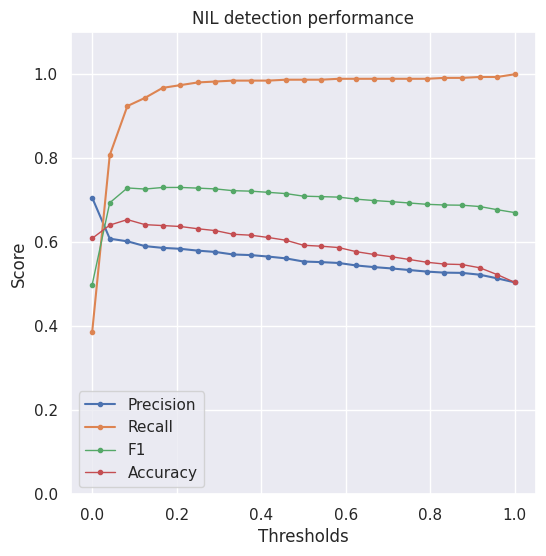

In [25]:
# Plot precision-recall curve against thresholds
sns.set_context("paper")
sns.set_theme(style="darkgrid")
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.plot(thresholds, precisions, marker="o", label="Precision", markersize=3)
ax.plot(thresholds, recalls, marker="o", label="Recall", markersize=3)
ax.plot(thresholds, f1s, marker="o", label="F1", linewidth=1, markersize=3)
ax.plot(thresholds, accuracies, marker="o", label="Accuracy", linewidth=1, markersize=3)
ax.set_ylim(0, 1.1)
plt.legend()
plt.xlabel("Thresholds")
plt.ylabel("Score")
plt.title("NIL detection performance")
plt.show()

In [26]:
threshold = 0.2
alligator_nil_tp = 0
alligator_nil_tn = 0
alligator_nil_fp = 0
alligator_nil_fn = 0
for i, (_, row) in enumerate(gt_only_annotations_df_sub.iterrows()):
    if row["candidates"] == 0 or row["score"] < threshold:
        if row["nil_label"] == "NIL":
            alligator_nil_tp += 1
        else:
            alligator_nil_fp += 1
    elif row["candidates"] > 0:
        assert row.prediction != "NIL"
        if row["nil_label"] != "NIL":
            alligator_nil_tn += 1
        else:
            # There's some candidates, score is above threshold but target is NIL
            alligator_nil_fn += 1
    else:
        raise ValueError("Unexpected case")
alligator_nil_recall = alligator_nil_tp / (alligator_nil_tp + alligator_nil_fn)
alligator_nil_precision = (
    alligator_nil_tp / (alligator_nil_tp + alligator_nil_fp) if alligator_nil_tp + alligator_nil_fp > 0 else 0
)
alligator_nil_f1 = (
    2 * (alligator_nil_precision * alligator_nil_recall) / (alligator_nil_precision + alligator_nil_recall)
    if alligator_nil_precision + alligator_nil_recall > 0
    else 0
)
alligator_nil_acc = (alligator_nil_tp + alligator_nil_tn) / (
    alligator_nil_tp + alligator_nil_tn + alligator_nil_fp + alligator_nil_fn
)
print("Alligator accuracy: {:.4f}".format(alligator_nil_acc))
print("Precision: {:.4f}".format(alligator_nil_precision))
print("Recall: {:.4f}".format(alligator_nil_recall))
print("F1: {:.4f}".format(alligator_nil_f1))

Alligator accuracy: 0.6386
Precision: 0.5852
Recall: 0.9740
F1: 0.7311


In [27]:
read_labels_and_descs_from_file = True
if read_labels_and_descs_from_file:
    with open("gh_test_babak_labels_and_descs.json", "r") as f:
        labels_and_descs = json.load(f)
else:
    labels_and_descs = {}

In [28]:
# Retrieve from wikidata infos about the NIL predictions
labels_and_descs_df = []
for row in tqdm.tqdm(
    gt_only_annotations_df_sub[
        (gt_only_annotations_df_sub["score"] >= 0.8) & (gt_only_annotations_df_sub["target"] == "NIL")
    ].itertuples(index=True)
):
    if row.prediction in labels_and_descs:
        labels_and_descs_df.append(
            {
                "index": row.Index,
                "prediction": row.prediction,
                "mention": row.mention,
                "wikidata_label": labels_and_descs[row.prediction]["label"],
                "wikidata_description": labels_and_descs[row.prediction]["desc"],
            }
        )
        continue
    params = {
        "action": "wbgetentities",
        "format": "json",
        "languages": "en",
        "ids": row.prediction,
        "props": "labels|descriptions",
    }
    wikidata_response = requests.get(
        "https://www.wikidata.org/w/api.php", params=params, headers={"User-Agent": wikidata_user_agent}
    )
    wikidata_response = wikidata_response.json()
    if wikidata_response is not None:
        labels_and_descs[row.prediction] = {
            "label": wikidata_response["entities"][row.prediction].get("labels", {}).get("en", {}).get("value", ""),
            "desc": wikidata_response["entities"][row.prediction]
            .get("descriptions", {})
            .get("en", {})
            .get("value", ""),
        }
        labels_and_descs_df.append(
            {
                "index": row.Index,
                "prediction": row.prediction,
                "mention": row.mention,
                "wikidata_label": wikidata_response["entities"][row.prediction]
                .get("labels", {})
                .get("en", {})
                .get("value", ""),
                "wikidata_description": wikidata_response["entities"][row.prediction]
                .get("descriptions", {})
                .get("en", {})
                .get("value", ""),
            }
        )
    else:
        labels_and_descs_df.append(
            {
                "index": row.Index,
                "prediction": row.prediction,
                "mention": row.mention,
                "wikidata_label": "",
                "wikidata_description": "",
            }
        )
        labels_and_descs_df.append(
            {
                "index": row.Index,
                "prediction": row.prediction,
                "mention": row.mention,
                "wikidata_label": "",
                "wikidata_description": "",
            }
        )
labels_and_descs_df = pd.DataFrame(labels_and_descs_df)
labels_and_descs_df = labels_and_descs_df.set_index("index", drop=True)
with open("gh_test_babak_labels_and_descs.json", "w+") as f:
    json.dump(labels_and_descs, f)

4it [00:00, 18275.83it/s]


In [29]:
labels_and_descs_df.reset_index(drop=True)

,prediction,mention,wikidata_label,wikidata_description
0,Q7503849,Shri Ramdeo Baba college of engineering and ma...,Shri Ramdeobaba College of Engineering and Man...,Indian private college in Maharashtra
1,Q24458592,Crisp Thinking / Google Certified Tensorflow D...,ESBE / Crisp,encyclopedic article
2,Q122275339,Phd of Nanjing Agricultural University,NANJING AGRICULTURAL UNIVERSITY,scholarly article in Journal of National Acade...
3,Q73024026,Executive Order builds complex systems for aut...,"Management, leadership, and business",scientific article published on 01 October 1999


In [30]:
(labels_and_descs_df["mention"].str.lower() == labels_and_descs_df["wikidata_label"].str.lower()).sum().item(), len(
    labels_and_descs_df
), ((labels_and_descs_df["mention"].str.lower() == labels_and_descs_df["wikidata_label"].str.lower()).sum() / len(
    labels_and_descs_df
)).item()

(0, 4, 0.0)

In [31]:
read_wikidata_annotation_from_file = True
if read_wikidata_annotation_from_file:
    with open(os.path.join("gh_test_babak_wikidata_annotated_mentions.json"), "r") as f:
        annotated_mentions = json.load(f)
else:
    annotated_mentions = {}

In [32]:
# Annotate with wikidata
wikidata_predictions = []
for row in tqdm.tqdm(gt_only_annotations_df_sub.itertuples(index=True), total=len(gt_only_annotations_df_sub)):
    mention = row.mention
    if mention in annotated_mentions:
        wikidata_predictions.append(
            {"index": row.Index, "wikidata_prediction": annotated_mentions[mention]["wikidata_prediction"]}
        )
        continue
    params = {
        "action": "wbsearchentities",
        "format": "json",
        "language": "en",
        "search": mention,
        "limit": 5,
    }
    headers = {"User-Agent": wikidata_user_agent}
    wikidata_response = requests.get("https://www.wikidata.org/w/api.php", params=params, headers=headers)
    wikidata_response = wikidata_response.json()
    if wikidata_response is not None:
        annotated_mentions[mention] = {
            "index": row.Index,
            "wikidata_prediction": (
                wikidata_response["search"][0]["id"] if len(wikidata_response["search"]) > 0 else ""
            ),
        }
        wikidata_predictions.append(annotated_mentions[mention])
json.dump(annotated_mentions, open("gh_test_babak_wikidata_annotated_mentions.json", "w+"))

100%|██████████| 916/916 [00:00<00:00, 282935.60it/s]


In [33]:
wikidata_predictions_df = pd.DataFrame(wikidata_predictions)
wikidata_predictions_df = wikidata_predictions_df.set_index("index", drop=True)
wikidata_predictions_df

,wikidata_prediction
index,
0,
1,Q285400
2,
3,Q21285890
4,
...,...
911,
912,
913,


In [34]:
pd.merge(gt_only_annotations_df_sub, wikidata_predictions_df, left_index=True, right_index=True, sort=False)

,table_name,row,col,candidates,score,target,prediction,target_in_candidates,mention,alligator_match,nil_label,nil_prediction@0.2,nil_match@0.2,wikidata_prediction
0,Github_Testset,101,0,0,0.000,NIL,,False,@bytemine-io,1,NIL,NIL,1,
1,Github_Testset,102,0,50,0.024,NIL,Q17224798,False,Flare,0,NIL,NIL,1,Q285400
2,Github_Testset,103,0,0,0.000,NIL,,False,Idelica,1,NIL,NIL,1,
3,Github_Testset,104,0,31,0.040,NIL,Q37546733,False,Trajano,0,NIL,NIL,1,Q21285890
4,Github_Testset,105,0,0,0.000,NIL,,False,niway.dev,1,NIL,NIL,1,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
911,Github_Testset,846,0,49,0.430,Q686329,Q686329,True,banco de la rep blica,1,Not NIL,Q686329,1,
912,Github_Testset,847,0,42,0.603,Q689617,Q689617,True,USI - University of Lugano,1,Not NIL,Q689617,1,
913,Github_Testset,848,0,0,0.000,Q690639,,False,https://www.aau.at,0,Not NIL,NIL,0,
914,Github_Testset,849,0,35,0.038,Q6944541,Q6944541,True,Mugla Sitki Koçman University,1,Not NIL,NIL,0,Q6944541


In [35]:
gt_only_annotations_df_sub = pd.merge(gt_only_annotations_df_sub, wikidata_predictions_df, left_index=True, right_index=True)
gt_only_annotations_df_sub

,table_name,row,col,candidates,score,target,prediction,target_in_candidates,mention,alligator_match,nil_label,nil_prediction@0.2,nil_match@0.2,wikidata_prediction
0,Github_Testset,101,0,0,0.000,NIL,,False,@bytemine-io,1,NIL,NIL,1,
1,Github_Testset,102,0,50,0.024,NIL,Q17224798,False,Flare,0,NIL,NIL,1,Q285400
2,Github_Testset,103,0,0,0.000,NIL,,False,Idelica,1,NIL,NIL,1,
3,Github_Testset,104,0,31,0.040,NIL,Q37546733,False,Trajano,0,NIL,NIL,1,Q21285890
4,Github_Testset,105,0,0,0.000,NIL,,False,niway.dev,1,NIL,NIL,1,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
911,Github_Testset,846,0,49,0.430,Q686329,Q686329,True,banco de la rep blica,1,Not NIL,Q686329,1,
912,Github_Testset,847,0,42,0.603,Q689617,Q689617,True,USI - University of Lugano,1,Not NIL,Q689617,1,
913,Github_Testset,848,0,0,0.000,Q690639,,False,https://www.aau.at,0,Not NIL,NIL,0,
914,Github_Testset,849,0,35,0.038,Q6944541,Q6944541,True,Mugla Sitki Koçman University,1,Not NIL,NIL,0,Q6944541


In [36]:
wikidata_tp = 0
wikidata_tn = 0
wikidata_fn = 0
wikidata_fp = 0
for row in gt_only_annotations_df_sub.itertuples(index=False):
    if row.wikidata_prediction == "":  # The prediction is NIL
        if row.nil_label == "NIL":
            wikidata_tp += 1
        else:
            wikidata_fp += 1
    else:  # Prediction is QID
        if row.nil_label == "NIL":
            wikidata_fn += 1
        else:
            wikidata_tn += 1
wikidata_recall = wikidata_tp / (wikidata_tp + wikidata_fn)
wikidata_precision = wikidata_tp / (wikidata_tp + wikidata_fp)
wikidata_f1 = 2 * (wikidata_precision * wikidata_recall) / (wikidata_precision + wikidata_recall)
wikidata_acc = (wikidata_tp + wikidata_tn) / (wikidata_tp + wikidata_tn + wikidata_fp + wikidata_fn)
print("Accuracy: {:.4f}".format(wikidata_acc))
print("Precision: {:.4f}".format(wikidata_precision))
print("Recall: {:.4f}".format(wikidata_recall))
print("F1: {:.4f}".format(wikidata_f1))

Accuracy: 0.6485
Precision: 0.6115
Recall: 0.8312
F1: 0.7046


In [37]:
# Prediction with NIL threshold = 0.2
gt_only_annotations_df_sub["wikidata_match"] = (np.where(
    gt_only_annotations_df_sub["wikidata_prediction"] != "",
    gt_only_annotations_df_sub["prediction"],
    "NIL",
) == gt_only_annotations_df_sub["target"]).astype(int)

In [38]:
gt_only_annotations_df_sub.to_csv(os.path.join(results_dir, dataset_name, f"alligator_results_subset_all.csv"), index=False)

### TableLlama analysis

In [39]:
gt_path = "/home/belerico/Desktop/unimib/business cases/gh/gh_test_babak/gt/cea_gt.csv"
results_path = "/home/belerico/Desktop/unimib/business cases/gh/results_gh_test_babak_llms/gh_test_babak_tablellama_with_analysis/gh_test_babak_end_to_end_prompts_analysis.json"

In [40]:
results = json.load(open(results_path))

In [41]:
gt = pd.read_csv(gt_path, header=None)
gt.columns = ["table_name", "row", "col", "qid"]
tables_names = gt["table_name"].unique().tolist()
url_regex = re.compile(r"http(s)?\:\/\/www\.wikidata\.org\/(wiki|entity)\/")
gt["qid"] = gt["qid"].map(lambda x: url_regex.sub("", x))
gt_mapping = {f"{row.table_name}-{row.row}-{row.col}": {"target": row.qid} for row in gt.itertuples()}

In [42]:
gt

,table_name,row,col,qid
0,Github_Testset,1,0,NIL
1,Github_Testset,2,0,NIL
2,Github_Testset,3,0,NIL
3,Github_Testset,4,0,NIL
4,Github_Testset,5,0,NIL
...,...,...,...,...
911,Github_Testset,912,0,Q986087
912,Github_Testset,913,0,Q99286585
913,Github_Testset,914,0,Q99287916
914,Github_Testset,915,0,Q99298800


In [43]:
tablellama_df = []
for example in results:
    tablellama_df.append(
        {
            "target": example["qid"],
            "table_name": example["table_id"],
            "row": example["entity"][0][0] + 1,
            "col": example["entity"][0][1],
            "target_in_candidates": example["target_in_candidates"],
            "tablellama_output": example["tablellama_output"],
            "tablellama_match": example["correct"],
            "tablellama_no_space_match": int(
                "".join(example["output"].replace("DESCRIPTION", "DESC").lower().split())
                in "".join(example["tablellama_output"].split())
            ),
            "gt_output": example["output"],
            "mention": example["entity"][1],
            "candidates": example["candidates_count"],
        }
    )

In [44]:
tablellama_df = pd.DataFrame(tablellama_df)
tablellama_df

,target,table_name,row,col,target_in_candidates,tablellama_output,tablellama_match,tablellama_no_space_match,gt_output,mention,candidates
0,NIL,Github_Testset,1,0,False,"<ia [desc] design agency [type] business,desig...",0,0,<NIL [DESCRIPTION] Not In List [TYPE] None>,9 IA,49
1,NIL,Github_Testset,2,0,False,<ml [desc] technology [type] >,0,0,<NIL [DESCRIPTION] Not In List [TYPE] None>,ML Engineer @Neovotech,51
2,NIL,Github_Testset,3,0,False,"<northampton, pa [desc] borough in pennsylvani...",0,0,<NIL [DESCRIPTION] Not In List [TYPE] None>,"Northampton, Atom Studio, Luyus Tea House",49
3,NIL,Github_Testset,4,0,False,<nil [desc] not in list [type] none>,1,1,<NIL [DESCRIPTION] Not In List [TYPE] None>,Pixtolab,1
4,NIL,Github_Testset,5,0,False,<mzn [desc] airport in papua new guinea [type]...,0,0,<NIL [DESCRIPTION] Not In List [TYPE] None>,MZN Digital,48
...,...,...,...,...,...,...,...,...,...,...,...
911,Q986087,Github_Testset,912,0,True,<westlake university [desc] private higher edu...,0,0,<Zhejiang University of Technology [DESCRIPTIO...,Zhejiang University & Westlake University,48
912,Q99286585,Github_Testset,913,0,False,<2022 in bellator mma [desc] bellator mixed ma...,0,0,<McGill University Desautels Faculty of Manage...,McGill MMA 2022,47
913,Q99287916,Github_Testset,914,0,True,<troy university sorrell college of business -...,1,1,<Troy University Sorrell College of Business -...,"Troy University, Sorrel College of Business",51
914,Q99298800,Github_Testset,915,0,True,<ajou university school of medicine and gradua...,1,1,<Ajou University School of Medicine and Gradua...,Biomedical Informatics / Ajou University Schoo...,47


In [45]:
# tablellama_df = get_subset(tablellama_df, subset)
# tablellama_df

In [99]:
tllama_tp = 0
tllama_fp = 0
tllama_tn = 0
tllama_fn = 0
for row in tablellama_df.itertuples(index=False):
    is_pred_nil = "nil [desc] not in list [type] none" in row.tablellama_output.lower()
    if row.target == "NIL":
        if is_pred_nil:
            tllama_tp += 1
        else:
            tllama_fn += 1
    else:  # target is a QID
        if is_pred_nil:  # TableLlama predicted a QID
            tllama_fp += 1
        else:
            tllama_tn += 1
tllama_recall = tllama_tp / (tllama_tp + tllama_fn)
tllama_precision = tllama_tp / (tllama_tp + tllama_fp)
tllama_f1 = 2 * (tllama_precision * tllama_recall) / (tllama_precision + tllama_recall)
# tllama_acc = (tablellama_df["tablellama_match"].astype(bool) | tablellama_df["tablellama_no_space_match"].astype(bool)).astype(int).mean()
tllama_acc = (tllama_tp + tllama_tn) / (tllama_tp + tllama_tn + tllama_fp + tllama_fn)
print("Accuracy: {:.4f}".format(tllama_acc))
print("Precision: {:.4f}".format(tllama_precision))
print("Recall: {:.4f}".format(tllama_recall))
print("F1: {:.4f}".format(tllama_f1))

Accuracy: 0.6179
Precision: 0.7154
Recall: 0.4026
F1: 0.5152


### GPT-4o analysis

In [100]:
gt_path = "/home/belerico/Desktop/unimib/business cases/gh/gh_test_babak/gt/cea_gt.csv"
results_path = "/home/belerico/Desktop/unimib/business cases/gh/results_gh_test_babak_llms/gpt-4o-mini/gh_test_babak_tablellama_prompts/gh_test_babak_end_to_end_prompts_gpt-4o-mini.json"

In [101]:
results = json.load(open(results_path))

In [102]:
gt = pd.read_csv(gt_path, header=None)
gt.columns = ["table_name", "row", "col", "qid"]
tables_names = gt["table_name"].unique().tolist()
url_regex = re.compile(r"http(s)?\:\/\/www\.wikidata\.org\/(wiki|entity)\/")
gt["qid"] = gt["qid"].map(lambda x: url_regex.sub("", x))
gt_mapping = {f"{row.table_name}-{row.row}-{row.col}": {"target": row.qid} for row in gt.itertuples()}

In [103]:
gt

,table_name,row,col,qid
0,Github_Testset,1,0,NIL
1,Github_Testset,2,0,NIL
2,Github_Testset,3,0,NIL
3,Github_Testset,4,0,NIL
4,Github_Testset,5,0,NIL
...,...,...,...,...
911,Github_Testset,912,0,Q986087
912,Github_Testset,913,0,Q99286585
913,Github_Testset,914,0,Q99287916
914,Github_Testset,915,0,Q99298800


In [104]:
cand_pat = re.compile(r"(?<=\<).+?(?=\>)")

In [105]:
cand_lengths = []
for example in results:
    question = example["question"]
    cand_lengths.append(len(cand_pat.findall(question)))

In [106]:
gpt_df = []
for i, example in enumerate(results):
    gpt_df.append(
        {
            "target": example["qid"],
            "table_name": example["table_id"],
            "row": example["entity"][0][0] + 1,
            "col": example["entity"][0][1],
            "target_in_candidates": example["target_in_candidates"],
            "gpt_output": example["gpt_output"],
            "gpt_match": example["gpt_correct"],
            "gpt_no_space_match": int(
                "".join(example["output"].lower().split())
                in "".join(example["gpt_output"].split())
            ),
            "gt_output": example["output"],
            "mention": example["entity"][1],
            "candidates": cand_lengths[i],
        }
    )

In [107]:
gpt_df = pd.DataFrame(gpt_df)
gpt_df

,target,table_name,row,col,target_in_candidates,gpt_output,gpt_match,gpt_no_space_match,gt_output,mention,candidates
0,NIL,Github_Testset,1,0,False,nil,1,0,<NIL [DESCRIPTION] Not In List [TYPE] None>,9 IA,49
1,NIL,Github_Testset,2,0,False,nil,1,0,<NIL [DESCRIPTION] Not In List [TYPE] None>,ML Engineer @Neovotech,51
2,NIL,Github_Testset,3,0,False,nil,1,0,<NIL [DESCRIPTION] Not In List [TYPE] None>,"Northampton, Atom Studio, Luyus Tea House",49
3,NIL,Github_Testset,4,0,False,nil [description] not in list [type] none,1,0,<NIL [DESCRIPTION] Not In List [TYPE] None>,Pixtolab,1
4,NIL,Github_Testset,5,0,False,nil,1,0,<NIL [DESCRIPTION] Not In List [TYPE] None>,MZN Digital,48
...,...,...,...,...,...,...,...,...,...,...,...
911,Q986087,Github_Testset,912,0,True,nil,0,0,<Zhejiang University of Technology [DESCRIPTIO...,Zhejiang University & Westlake University,48
912,Q99286585,Github_Testset,913,0,False,nil,0,0,<McGill University Desautels Faculty of Manage...,McGill MMA 2022,47
913,Q99287916,Github_Testset,914,0,True,<troy university sorrell college of business -...,1,1,<Troy University Sorrell College of Business -...,"Troy University, Sorrel College of Business",51
914,Q99298800,Github_Testset,915,0,True,<ajou university school of medicine and gradua...,1,1,<Ajou University School of Medicine and Gradua...,Biomedical Informatics / Ajou University Schoo...,47


In [108]:
gpt_df[gpt_df["gpt_output"].str.contains("nil", case=False)]

,target,table_name,row,col,target_in_candidates,gpt_output,gpt_match,gpt_no_space_match,gt_output,mention,candidates
0,NIL,Github_Testset,1,0,False,nil,1,0,<NIL [DESCRIPTION] Not In List [TYPE] None>,9 IA,49
1,NIL,Github_Testset,2,0,False,nil,1,0,<NIL [DESCRIPTION] Not In List [TYPE] None>,ML Engineer @Neovotech,51
2,NIL,Github_Testset,3,0,False,nil,1,0,<NIL [DESCRIPTION] Not In List [TYPE] None>,"Northampton, Atom Studio, Luyus Tea House",49
3,NIL,Github_Testset,4,0,False,nil [description] not in list [type] none,1,0,<NIL [DESCRIPTION] Not In List [TYPE] None>,Pixtolab,1
4,NIL,Github_Testset,5,0,False,nil,1,0,<NIL [DESCRIPTION] Not In List [TYPE] None>,MZN Digital,48
...,...,...,...,...,...,...,...,...,...,...,...
902,Q930528,Github_Testset,903,0,True,nil,0,0,<University of Trento [DESCRIPTION] Italian un...,"Thema Optical, University of Trento",43
904,Q93965558,Github_Testset,905,0,False,nil [description] not in list [type] none,0,0,"<Ajay Kumar Garg Engineering College, Ghaziaba...",DSC-AKGEC,1
905,Q95,Github_Testset,906,0,True,nil,0,0,<Google [DESCRIPTION] American multinational t...,Student at Google,51
911,Q986087,Github_Testset,912,0,True,nil,0,0,<Zhejiang University of Technology [DESCRIPTIO...,Zhejiang University & Westlake University,48


In [109]:
# gpt_df = get_subset(gpt_df, subset)
# gpt_df

In [110]:
gpt_tp = 0
gpt_fp = 0
gpt_tn = 0
gpt_fn = 0
for row in gpt_df.itertuples(index=False):
    is_pred_nil = ("nil [description] not in list [type] none" in row.gpt_output.lower()) or (
        "nil" == row.gpt_output.lower()
    )
    if row.target == "NIL":
        if is_pred_nil:
            gpt_tp += 1
        else:
            gpt_fn += 1
    else:  # target is a QID
        if is_pred_nil:  # TableLlama predicted a QID
            gpt_fp += 1
        else:
            gpt_tn += 1
gpt_recall = gpt_tp / (gpt_tp + gpt_fn)
gpt_precision = gpt_tp / (gpt_tp + gpt_fp)
gpt_f1 = 2 * (gpt_precision * gpt_recall) / (gpt_precision + gpt_recall)
gpt_acc = (gpt_tp + gpt_tn) / (gpt_tp + gpt_tn + gpt_fp + gpt_fn)
print("Accuracy: {:.4f}".format(gpt_acc))
print("Precision: {:.4f}".format(gpt_precision))
print("Recall: {:.4f}".format(gpt_recall))
print("F1: {:.4f}".format(gpt_f1))

Accuracy: 0.7467
Precision: 0.6849
Recall: 0.9221
F1: 0.7860


### Gemma2 9B analysis

In [111]:
gt_path = "/home/belerico/Desktop/unimib/business cases/gh/gh_test_babak/gt/cea_gt.csv"
results_path = "/home/belerico/Desktop/unimib/business cases/gh/results_gh_test_babak_llms/google/gemma-2-2b-it_with_analysis/gh_test_babak_end_to_end_prompts_analysis.json"

In [112]:
results = json.load(open(results_path))

In [113]:
gt = pd.read_csv(gt_path, header=None)
gt.columns = ["table_name", "row", "col", "qid"]
tables_names = gt["table_name"].unique().tolist()
url_regex = re.compile(r"http(s)?\:\/\/www\.wikidata\.org\/(wiki|entity)\/")
gt["qid"] = gt["qid"].map(lambda x: url_regex.sub("", x))
gt_mapping = {f"{row.table_name}-{row.row}-{row.col}": {"target": row.qid} for row in gt.itertuples()}
gt

,table_name,row,col,qid
0,Github_Testset,1,0,NIL
1,Github_Testset,2,0,NIL
2,Github_Testset,3,0,NIL
3,Github_Testset,4,0,NIL
4,Github_Testset,5,0,NIL
...,...,...,...,...
911,Github_Testset,912,0,Q986087
912,Github_Testset,913,0,Q99286585
913,Github_Testset,914,0,Q99287916
914,Github_Testset,915,0,Q99298800


In [114]:
cand_pat = re.compile(r"(?<=\<).+?(?=\>)")
cand_lengths = []
for example in results:
    question = example["question"]
    cand_lengths.append(len(cand_pat.findall(question)))

In [115]:
gemma2_df = []
for i, example in enumerate(results):
    gemma2_df.append(
        {
            "target": example["qid"],
            "table_name": example["table_id"],
            "row": example["entity"][0][0] + 1,
            "col": example["entity"][0][1],
            "target_in_candidates": example["target_in_candidates"],
            "llm_output": example["llm_output"],
            "llm_match": example["llm_correct"] if "llm_correct" in example else example["correct"],
            "llm_no_space_match": int(
                ("".join(example["output"].lower().split())
                in "".join(example["llm_output"].split())) or (
                    "".join(example["llm_output"].lower().split())
                in "".join(example["output"].split())
                )
            ),
            "gt_output": example["output"],
            "mention": example["entity"][1],
            "candidates": cand_lengths[i],
        }
    )

In [116]:
gemma2_df = pd.DataFrame(gemma2_df)
gemma2_df

,target,table_name,row,col,target_in_candidates,llm_output,llm_match,llm_no_space_match,gt_output,mention,candidates
0,NIL,Github_Testset,1,0,False,"ia 1 [description] state highway in iowa, unit...",0,0,<NIL [DESCRIPTION] Not In List [TYPE] None>,9 IA,49
1,NIL,Github_Testset,2,0,False,"engineer [description] company, [type] human,o...",0,0,<NIL [DESCRIPTION] Not In List [TYPE] None>,ML Engineer @Neovotech,51
2,NIL,Github_Testset,3,0,False,"northampton, pa [description] borough in penns...",0,0,<NIL [DESCRIPTION] Not In List [TYPE] None>,"Northampton, Atom Studio, Luyus Tea House",49
3,NIL,Github_Testset,4,0,False,pixtolab [description] company [type],0,0,<NIL [DESCRIPTION] Not In List [TYPE] None>,Pixtolab,1
4,NIL,Github_Testset,5,0,False,digital [description] u.s. corporation [type] ...,0,0,<NIL [DESCRIPTION] Not In List [TYPE] None>,MZN Digital,48
...,...,...,...,...,...,...,...,...,...,...,...
911,Q986087,Github_Testset,912,0,True,zhejiang university & westlake university [des...,0,0,<Zhejiang University of Technology [DESCRIPTIO...,Zhejiang University & Westlake University,48
912,Q99286585,Github_Testset,913,0,False,nil,0,0,<McGill University Desautels Faculty of Manage...,McGill MMA 2022,47
913,Q99287916,Github_Testset,914,0,True,troy university sorrell college of business - ...,1,0,<Troy University Sorrell College of Business -...,"Troy University, Sorrel College of Business",51
914,Q99298800,Github_Testset,915,0,True,ajou university school of medicine [descriptio...,0,0,<Ajou University School of Medicine and Gradua...,Biomedical Informatics / Ajou University Schoo...,47


In [117]:
gemma2_tp = 0
gemma2_fp = 0
gemma2_tn = 0
gemma2_fn = 0
for row in gemma2_df.itertuples(index=False):
    is_pred_nil = ("nil [description] not in list [type] none" in row.llm_output.lower()) or (
        "nil" == row.llm_output.lower()
    )
    if row.target == "NIL":
        if is_pred_nil:
            gemma2_tp += 1
        else:
            gemma2_fn += 1
    else:
        if is_pred_nil:  # TableLlama predicted a QID
            gemma2_fp += 1
        else:
            gemma2_tn += 1
gemma2_recall = gemma2_tp / (gemma2_tp + gemma2_fn)
gemma2_precision = gemma2_tp / (gemma2_tp + gemma2_fp)
gemma2_f1 = 2 * (gemma2_precision * gemma2_recall) / (gemma2_precision + gemma2_recall)
# gemma2_acc = (tablellama_df["tablellama_match"].astype(bool) | tablellama_df["tablellama_no_space_match"].astype(bool)).astype(int).mean()
gemma2_acc = (gemma2_tp + gemma2_tn) / (gemma2_tp + gemma2_tn + gemma2_fp + gemma2_fn)
print("Accuracy: {:.4f}".format(gemma2_acc))
print("Precision: {:.4f}".format(gemma2_precision))
print("Recall: {:.4f}".format(gemma2_recall))
print("F1: {:.4f}".format(gemma2_f1))

Accuracy: 0.5197
Precision: 0.6375
Recall: 0.1104
F1: 0.1882


### Plot all scores

In [134]:
scores_df = {
    "Alligator": [alligator_precision, alligator_recall, alligator_f1],  # alligator_acc],
    "Alligator nil@0.2": [alligator_nil_precision, alligator_nil_recall, alligator_nil_f1],  # alligator_nil_acc],
    "TableLlama-7B": [tllama_precision, tllama_recall, tllama_f1],  # tllama_acc],
    "GPT-4o-mini": [gpt_precision, gpt_recall, gpt_f1],  # gpt_acc],
    # "Gemma2-2B": [gemma2_precision, gemma2_recall, gemma2_f1],  # gemma2_acc],
    "Wikidata": [wikidata_precision, wikidata_recall, wikidata_f1],  # wikidata_acc],
}
scores_df = pd.DataFrame(scores_df, index=["Precision", "Recall", "F1"]).reset_index(names="metric")
scores_df

,metric,Alligator,Alligator nil@0.2,TableLlama-7B,GPT-4o-mini,Wikidata
0,Precision,0.715447,0.585176,0.715385,0.684887,0.611465
1,Recall,0.380952,0.974026,0.402597,0.922078,0.831169
2,F1,0.497175,0.731113,0.515235,0.785978,0.704587


In [135]:
scores_df = scores_df.melt(id_vars="metric", var_name="Approach", value_name="Value")
scores_df

,metric,Approach,Value
0,Precision,Alligator,0.715447
1,Recall,Alligator,0.380952
2,F1,Alligator,0.497175
3,Precision,Alligator nil@0.2,0.585176
4,Recall,Alligator nil@0.2,0.974026
5,F1,Alligator nil@0.2,0.731113
6,Precision,TableLlama-7B,0.715385
7,Recall,TableLlama-7B,0.402597
8,F1,TableLlama-7B,0.515235
9,Precision,GPT-4o-mini,0.684887


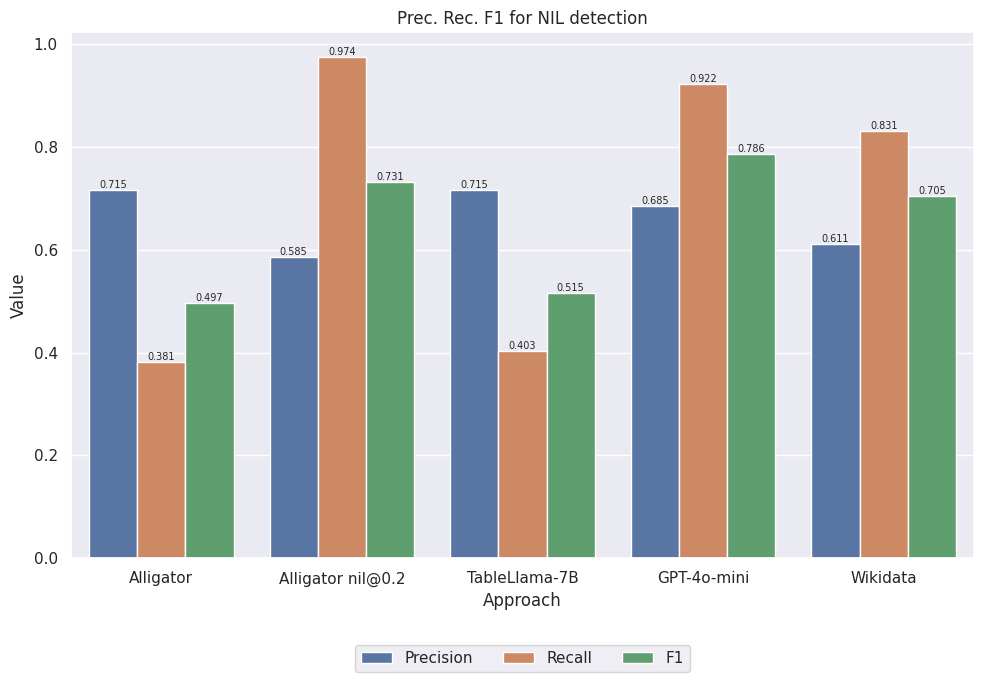

In [136]:
sns.set_context("paper")
sns.set_theme(style="darkgrid")
fig, ax = plt.subplots(1, 1, figsize=(10, 7))
sns.barplot(
    scores_df,
    x="Approach",
    y="Value",
    hue="metric",
    ax=ax,
    legend=True,
)
for container in ax.containers:
    ax.bar_label(container, fmt="%.3f", fontsize=7)
ax.set_title(f"Prec. Rec. F1 for NIL detection")
plt.legend()
sns.move_legend(ax, "upper center", bbox_to_anchor=(0.5, -0.15), ncols=4)
plt.tight_layout()
plt.show()

### Not-NIL accuracy per approach

In [137]:
# Compute the NIL accuracy per approach
nil_accuracy_by_approach = {
    "Alligator": gt_only_annotations_df_sub[gt_only_annotations_df_sub["target"] != "NIL"]["alligator_match"].mean(),
    "Alligator nil@0.2": gt_only_annotations_df_sub[gt_only_annotations_df_sub["target"] != "NIL"]["nil_match@0.2"].mean(),
    "TableLlama-7B": tablellama_df[tablellama_df["target"] != "NIL"]["tablellama_match"].mean(),
    # "Gemma2-2B": gemma2_df[gemma2_df["target"] != "NIL"]["llm_match"].mean(),
    "GPT-4o-mini": gpt_df[gpt_df["target"] != "NIL"]["gpt_match"].mean(),
    "Wikidata": gt_only_annotations_df_sub[gt_only_annotations_df_sub["target"] != "NIL"]["wikidata_match"].mean(),
}

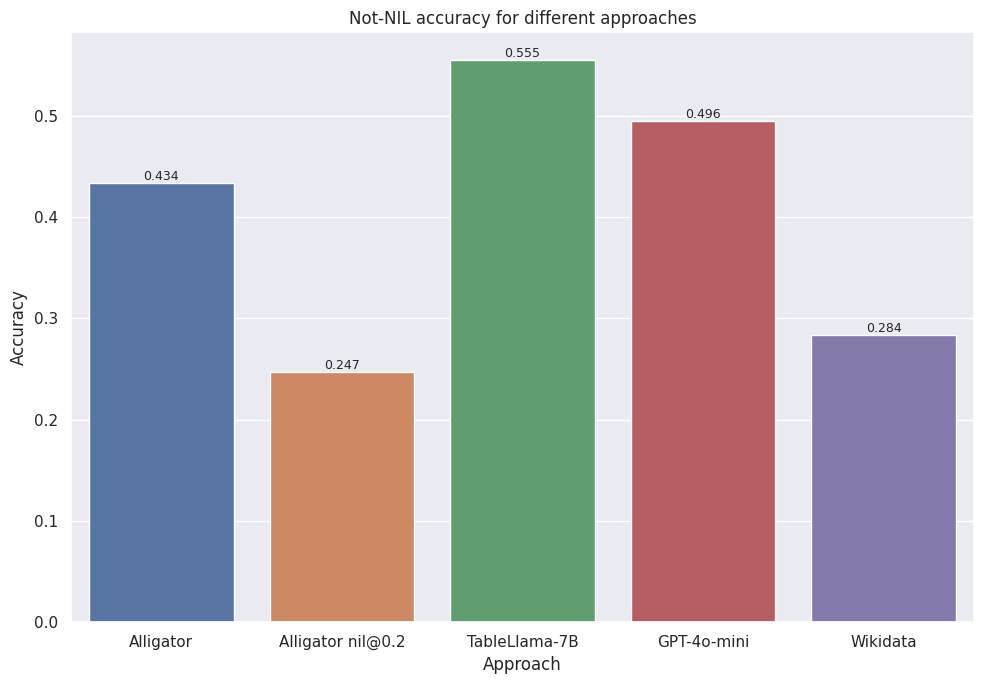

In [138]:
# Plot the results
sns.set_context("paper")
sns.set_theme(style="darkgrid")
fig, ax = plt.subplots(1, 1, figsize=(10, 7))
sns.barplot(
    x=list(nil_accuracy_by_approach.keys()),
    y=list(nil_accuracy_by_approach.values()),
    ax=ax,
    legend=False,
    hue=list(nil_accuracy_by_approach.keys()),
)
for container in ax.containers:
    ax.bar_label(container, fmt="%.3f", fontsize=9)
ax.set_title(f"Not-NIL accuracy for different approaches")
ax.set_xlabel("Approach")
ax.set_ylabel("Accuracy")
plt.tight_layout()
plt.show()

### Overall accuracy per approach

In [139]:
# Compute the NIL accuracy per approach
accuracy_by_approach = {
    "Alligator": gt_only_annotations_df_sub["alligator_match"].mean(),
    "Alligator nil@0.2": gt_only_annotations_df_sub["nil_match@0.2"].mean(),
    "TableLlama-7B": tablellama_df["tablellama_match"].mean(),
    # "Gemma2-2B": gemma2_df["llm_match"].mean(),
    "GPT-4o-mini": gpt_df["gpt_match"].mean(),
    "Wikidata": gt_only_annotations_df_sub["wikidata_match"].mean(),
}

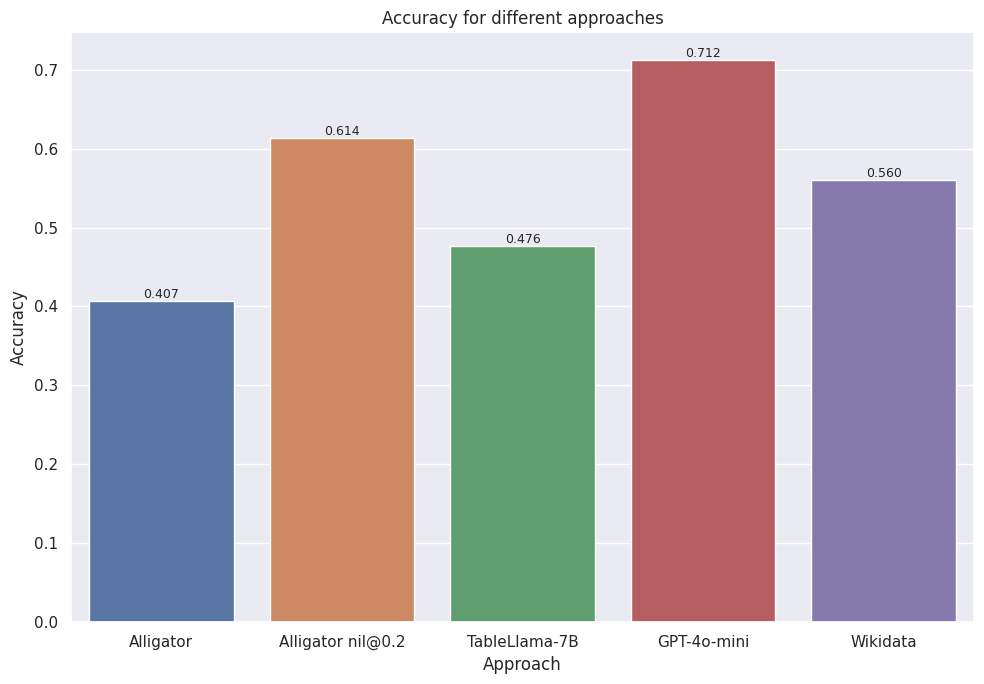

In [140]:
# Plot the results
sns.set_context("paper")
sns.set_theme(style="darkgrid")
fig, ax = plt.subplots(1, 1, figsize=(10, 7))
sns.barplot(
    x=list(accuracy_by_approach.keys()),
    y=list(accuracy_by_approach.values()),
    ax=ax,
    legend=False,
    hue=list(accuracy_by_approach.keys()),
)
for container in ax.containers:
    ax.bar_label(container, fmt="%.3f", fontsize=9)
ax.set_title(f"Accuracy for different approaches")
ax.set_xlabel("Approach")
ax.set_ylabel("Accuracy")
plt.tight_layout()
plt.show()

### Other statistics

In [ ]:
len(
    gt_only_annotations_df_sub[
        (gt_only_annotations_df_sub["target"] == "NIL")
        & (gt_only_annotations_df_sub["nil_match@0.2"] == 1)
        & (gt_only_annotations_df_sub["candidates"] >= 10)
    ]
), len(
    gt_only_annotations_df_sub[
        (gt_only_annotations_df_sub["target"] == "NIL") & (gt_only_annotations_df_sub["nil_match@0.2"] == 1)
    ]
), len(
    gt_only_annotations_df_sub[
        (gt_only_annotations_df_sub["target"] == "NIL")
        & (gt_only_annotations_df_sub["nil_match@0.2"] == 1)
        & (gt_only_annotations_df_sub["candidates"] >= 10)
    ]
) / len(
    gt_only_annotations_df_sub[
        (gt_only_annotations_df_sub["target"] == "NIL") & (gt_only_annotations_df_sub["nil_match@0.2"] == 1)
    ]
)

In [ ]:
len(
    tablellama_df[
        (tablellama_df["target"] == "NIL")
        & (tablellama_df["tablellama_match"] == 1)
        & (tablellama_df["candidates"] >= 10)
    ]
), len(tablellama_df[(tablellama_df["target"] == "NIL") & (tablellama_df["tablellama_match"] == 1)]), len(
    tablellama_df[
        (tablellama_df["target"] == "NIL")
        & (tablellama_df["tablellama_match"] == 1)
        & (tablellama_df["candidates"] >= 10)
    ]
) / len(
    tablellama_df[(tablellama_df["target"] == "NIL") & (tablellama_df["tablellama_match"] == 1)]
)

In [ ]:
len(gemma2_df[(gemma2_df["target"] == "NIL") & (gemma2_df["llm_match"] == 1) & (gemma2_df["candidates"] >= 10)]), len(
    gemma2_df[(gemma2_df["target"] == "NIL") & (gemma2_df["llm_match"] == 1)]
), len(
    gemma2_df[(gemma2_df["target"] == "NIL") & (gemma2_df["llm_match"] == 1) & (gemma2_df["candidates"] >= 10)]
) / len(
    gemma2_df[(gemma2_df["target"] == "NIL") & (gemma2_df["llm_match"] == 1)]
)

In [ ]:
len(gpt_df[(gpt_df["target"] == "NIL") & (gpt_df["gpt_match"] == 1) & (gpt_df["candidates"] >= 10)]), len(
    gpt_df[(gpt_df["target"] == "NIL") & (gpt_df["gpt_match"] == 1)]
), len(gpt_df[(gpt_df["target"] == "NIL") & (gpt_df["gpt_match"] == 1) & (gpt_df["candidates"] >= 10)]) / len(
    gpt_df[(gpt_df["target"] == "NIL") & (gpt_df["gpt_match"] == 1)]
)

In [75]:
lamapi_errors_by_approach = {
    "alligator": (
        len(
            gt_only_annotations_df_sub[
                (gt_only_annotations_df_sub["nil_match@0.2"] == 0)
                & (gt_only_annotations_df_sub["target_in_candidates"] == False)
                & (gt_only_annotations_df_sub["target"] != "NIL")
            ]
        ),
        len(
            gt_only_annotations_df_sub[
                (gt_only_annotations_df_sub["target"] != "NIL")
            ]
        ),
    ),
    "tablellama": (
        len(
            tablellama_df[
                (tablellama_df["tablellama_match"] == 0)
                & (tablellama_df["target_in_candidates"] == False)
                & (tablellama_df["target"] != "NIL")
            ]
        ),
        len(tablellama_df[ (tablellama_df["target"] != "NIL")]),
    ),
    "gpt4o": (
        len(
            gpt_df[(gpt_df["gpt_match"] == 0) & (gpt_df["target_in_candidates"] == False) & (gpt_df["target"] != "NIL")]
        ),
        len(gpt_df[(gpt_df["target"] != "NIL")]),
    ),
}

In [ ]:
lamapi_errors_by_approach

In [77]:
algo_errors_by_approach = {
    "alligator": (
        len(
            gt_only_annotations_df_sub[
                (gt_only_annotations_df_sub["alligator_match"] == 0)
                & (gt_only_annotations_df_sub["target_in_candidates"] == True)
                & (gt_only_annotations_df_sub["target"] != "NIL")
            ]
        ),
        len(
            gt_only_annotations_df_sub[
                (gt_only_annotations_df_sub["target"] != "NIL")
            ]
        ),
    ),
    "alligator nil@0.2": (
        len(
            gt_only_annotations_df_sub[
                (gt_only_annotations_df_sub["nil_match@0.2"] == 0)
                & (gt_only_annotations_df_sub["target_in_candidates"] == True)
                & (gt_only_annotations_df_sub["target"] != "NIL")
            ]
        ),
        len(
            gt_only_annotations_df_sub[
                (gt_only_annotations_df_sub["target"] != "NIL")
            ]
        ),
    ),
    "tablellama": (
        len(
            tablellama_df[
                (tablellama_df["tablellama_match"] == 0)
                & (tablellama_df["target_in_candidates"] == True)
                & (tablellama_df["target"] != "NIL")
            ]
        ),
        len(tablellama_df[ (tablellama_df["target"] != "NIL")]),
    ),
    "gpt4o": (
        len(
            gpt_df[(gpt_df["gpt_match"] == 0) & (gpt_df["target_in_candidates"] == True) & (gpt_df["target"] != "NIL")]
        ),
        len(gpt_df[(gpt_df["target"] != "NIL")]),
    ),
}

In [ ]:
algo_errors_by_approach

In [ ]:
tablellama_df[
    (tablellama_df["tablellama_match"] == 0)
    & (tablellama_df["target_in_candidates"] == False)
    & (tablellama_df["target"] != "NIL")
]["mention"].tolist()

In [80]:
tllama_wrong_mentions = set(
    tablellama_df[(tablellama_df["tablellama_match"] == 0) & (tablellama_df["target_in_candidates"] == 1)][
        "mention"
    ].tolist()
)

In [81]:
gpt_wrong_mentions = set(gpt_df[(gpt_df["gpt_match"] == 0) & (gpt_df["target_in_candidates"] == 1)]["mention"].tolist())

In [82]:
alligator_wrong_mentions = set(
    gt_only_annotations_df_sub[
        (gt_only_annotations_df_sub["nil_match@0.2"] == 0) & (gt_only_annotations_df_sub["target_in_candidates"] == 1)
    ]["mention"].tolist()
)

In [ ]:
iou_alligator_tablellama = len(tllama_wrong_mentions.intersection(alligator_wrong_mentions)) / len(
    tllama_wrong_mentions.union(alligator_wrong_mentions)
)
iou_alligator_tablellama

In [ ]:
iou_alligator_gpt = len(gpt_wrong_mentions.intersection(alligator_wrong_mentions)) / len(
    gpt_wrong_mentions.union(alligator_wrong_mentions)
)
iou_alligator_gpt

In [ ]:
iou_gpt_tablellama = len(tllama_wrong_mentions.intersection(gpt_wrong_mentions)) / len(
    tllama_wrong_mentions.union(gpt_wrong_mentions)
)
iou_gpt_tablellama

In [ ]:
alligator_wrong_mentions.difference(tllama_wrong_mentions)

In [ ]:
tllama_wrong_mentions.difference(alligator_wrong_mentions)

In [ ]:
alligator_wrong_mentions.intersection(tllama_wrong_mentions)

### GPT token and price estimation

In [93]:
results_path = "/home/belerico/Desktop/unimib/business cases/gh/results_gh_test_babak_llms/gpt-4o-mini/gh_test_babak_tablellama_prompts/gh_test_babak_end_to_end_prompts_gpt-4o-mini.json"

In [94]:
results = json.load(open(results_path))

In [95]:
prompt_template = (
    "Below is an instruction that describes a task, paired with an input that provides further context. "
    "Write a response that appropriately completes the request.\n\n"
    "### Instruction:\n{instruction}\n\n### Input:\n{input}\n\n### Question:\n{question}\n\n"
    "Repeat only the correct candidate, along with its description and types, if any, and nothing else. "
    "Answer with NIL if no correct candidate can be found in the candidate list.\n\n"
    "### Response:\n"
)

In [96]:
input_chars = 0
output_chars = 0
chars_to_token = 4
for example in results:
    input_chars += len(prompt_template.format(**example))
    output_chars += len(example["gpt_output"])
input_tokens = input_chars / chars_to_token
output_tokens = output_chars / chars_to_token

In [ ]:
input_tokens, output_tokens

In [97]:
input_tokens_price = 0.150 / 1e6
output_tokens_price = 0.6 / 1e6

In [ ]:
input_tokens_price * input_tokens

In [ ]:
output_tokens_price * output_tokens

In [ ]:
avg_row_input_chars = input_chars / len(results)
avg_row_output_chars = output_chars / len(results)

avg_row_input_tokens = avg_row_input_chars / chars_to_token
avg_row_output_tokens = avg_row_output_chars / chars_to_token

input_tokens_price * avg_row_input_tokens, output_tokens_price * avg_row_output_tokens

In [ ]:
input_tokens_price * avg_row_input_tokens + output_tokens_price * avg_row_output_tokens

### Feature distribution

In [97]:
all_features = {
    "ambiguity_mention",
    "ncorrects_tokens",
    "ntoken_mention",
    "ntoken_entity",
    "length_mention",
    "length_entity",
    "popularity",
    "pos_score",
    "es_score",
    "ed_score",
    "jaccard_score",
    "jaccardNgram_score",
    "p_subj_ne",
    "p_subj_lit_datatype",
    "p_subj_lit_all_datatype",
    "p_subj_lit_row",
    "p_obj_ne",
    "desc",
    "descNgram",
    "cta_t1",
    "cta_t2",
    "cta_t3",
    "cta_t4",
    "cta_t5",
    "cpa_t1",
    "cpa_t2",
    "cpa_t3",
    "cpa_t4",
    "cpa_t5",
}

In [98]:
features_df.to_csv(os.path.join(results_dir, dataset_name, f"alligator_features_subset_all.csv"), index=False)

In [ ]:
from sklearn.feature_selection import mutual_info_classif

X = features_df[features_df.columns[features_df.columns.isin(all_features)]]  # Your feature columns
y = features_df["target"]  # Your categorical target variable
mi = mutual_info_classif(X, y)

mutual_info = pd.Series(mi, index=X.columns)
print(mutual_info.sort_values(ascending=False))

In [ ]:
from sklearn.tree import DecisionTreeClassifier

X = features_df[features_df.columns[features_df.columns.isin(all_features)]]  # Your feature columns
y = features_df["target"]  # Your categorical target variable

# Fit a decision tree classifier
model = DecisionTreeClassifier()
model.fit(X, y)

# Get feature importances
feature_importances = pd.Series(model.feature_importances_, index=X.columns)
print(feature_importances.sort_values(ascending=False))